In [7]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()

num_cols = ['value'] #,"hour" 
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [9]:
import numpy as np

def sliding_windows_with_labels(df, window_size):
    labels = df["anomaly"].values
    data = df.drop(["anomaly"], axis=1).values

    X_windows = []
    y_labels = []

    for i in range(len(df) - window_size + 1):
        window = data[i:i+window_size]
        window_label = labels[i:i+window_size]

        X_windows.append(window)
        y_labels.append(float(any(window_label)))  # 윈도우에 이상치 하나라도 있으면 1

    return np.array(X_windows), np.array(y_labels)

In [11]:
window_size = 24
X_windows, y_labels = sliding_windows_with_labels(df, window_size)

print("X_windows shape:", X_windows.shape)  # (윈도우 개수, window_size, 특성 수)
print("y_labels shape:", y_labels.shape)    # (윈도우 개수,)

X_windows shape: (17257, 24, 1)
y_labels shape: (17257,)


In [13]:
from sklearn.utils import shuffle

X_shuffled, y_shuffled = shuffle(X_windows, y_labels, random_state=42)

In [15]:
import numpy as np

# 1. 이상치 여부에 따라 정렬 (label==0 먼저, label==1 나중)
normal_mask = y_shuffled == 0
anomaly_mask = y_shuffled == 1

X_normal = X_shuffled[normal_mask]
y_normal = y_shuffled[normal_mask]

X_anomaly = X_shuffled[anomaly_mask]
y_anomaly = y_shuffled[anomaly_mask]

# 다시 합치기: 정상 → 이상 순서
X_sorted = np.concatenate([X_normal, X_anomaly], axis=0)
y_sorted = np.concatenate([y_normal, y_anomaly], axis=0)

# 2. 6:2:2로 분할
total = len(X_sorted)
n_train = int(total * 0.6)
n_val = int(total * 0.2)

X_train = X_sorted[:n_train]
y_train = y_sorted[:n_train]

X_val = X_sorted[n_train:n_train + n_val]
y_val = y_sorted[n_train:n_train + n_val]

X_test = X_sorted[n_train + n_val:]
y_test = y_sorted[n_train + n_val:]

In [30]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

print("y_train 이상치 비율:", y_train.mean())
print("y_val 이상치 비율:", y_val.mean())
print("y_test 이상치 비율:", y_test.mean())

if y_val.sum() == 0:
    print("✅ val에는 이상치가 없습니다.")
else:
    print("❌ val에 이상치가 있습니다.")

X_train shape: (10354, 24, 1)
X_val shape: (3451, 24, 1)
X_test shape: (3452, 24, 1)
y_train 이상치 비율: 0.0
y_val 이상치 비율: 0.0
y_test 이상치 비율: 0.5538818076477404
✅ val에는 이상치가 없습니다.


In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

def build_regularized_lstm_ae(timesteps, features):
    inputs = Input(shape=(timesteps, features))

    # Encoder
    x = LSTM(32, return_sequences=True,
             kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = Dropout(0.3)(x)
    x = LSTM(16, return_sequences=False,
             kernel_regularizer=regularizers.l2(1e-4))(x)

    # Bottleneck
    x = RepeatVector(timesteps)(x)

    # Decoder
    x = LSTM(16, return_sequences=True,ㅁ
             kernel_regularizer=regularizers.l2(1e-4))(x)
    x = Dropout(0.3)(x)
    x = LSTM(32, return_sequences=True,
             kernel_regularizer=regularizers.l2(1e-4))(x)

    outputs = TimeDistributed(Dense(1))(x)

    model = Model(inputs, outputs)
    return model

# 모델 생성
model = build_regularized_lstm_ae(timesteps=24, features=1)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 24, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 24, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 24, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 24, 16)              │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 24, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 24, 32)              │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 24, 1)               │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,905 (62.13 KB)

 Trainable params: 15,905 (62.13 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=200,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0347 - val_loss: 0.0106
Epoch 2/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0101 - val_loss: 0.0063
Epoch 3/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0059 - val_loss: 0.0042
Epoch 4/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 5/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 6/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 7/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 8/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 9/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 10/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 11/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 12/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step

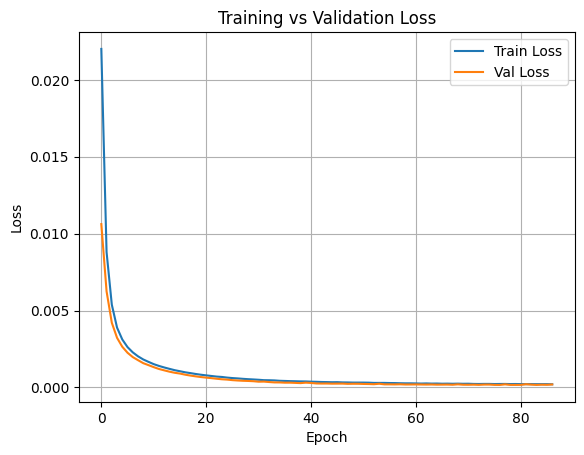

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
X_pred = model.predict(X_test)


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def evaluate_thresholds(errors, y_true, thresholds=500):
    best_f1 = 0
    best_threshold = 0
    best_scores = {}

    min_th, max_th = np.min(errors), np.max(errors)
    th_list = np.linspace(min_th, max_th, thresholds)

    for th in th_list:
        y_pred = (errors > th).astype(int)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = th
            best_scores = {
                'F1': f1,
                'Precision': precision,
                'Recall': recall,
                'Threshold': th,
                'AUC': roc_auc_score(y_true, errors)
            }

    return best_scores


In [38]:
from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score, roc_auc_score

# ✅ 모델 예측
# X_pred = autoencoder.predict(X_test)  # 또는 model.predict() ← 일관되게

# ✅ 재구성 오차 계산 (percentile 기반 or mean 기반)
errors = np.square(X_test - X_pred)
mse = np.percentile(errors, 90, axis=(1, 2))  # 또는 np.mean(errors, axis=(1, 2))

# ✅ AUC 기반 threshold 탐색 함수
def find_best_threshold_by_auc(y_true, errors):
    fpr, tpr, thresholds = roc_curve(y_true, errors)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    return thresholds[best_idx], fpr, tpr, thresholds

# ✅ 최적 threshold 찾기
best_threshold_auc, fpr, tpr, roc_thresholds = find_best_threshold_by_auc(y_test, mse)

# ✅ 성능 평가
y_pred_auc = (mse > best_threshold_auc).astype(int)
precision = precision_score(y_test, y_pred_auc)
recall = recall_score(y_test, y_pred_auc)
f1 = f1_score(y_test, y_pred_auc)
auc = roc_auc_score(y_test, mse)

print(f"🎯 [AUC 기준] 최적 Threshold: {best_threshold_auc:.6f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")


🎯 [AUC 기준] 최적 Threshold: 0.000389
Precision: 0.8526
Recall:    0.7777
F1 Score:  0.8135
AUC-ROC:   0.8532
